In [3]:
# copyright ############################### #
# This file is part of the Xtrack Package.  #
# Copyright (c) CERN, 2021.                 #
# ######################################### #


import ducktrack as dtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
from tqdm import tqdm

import xtrack as xt
import xobjects as xo
import xpart as xp


beta_rel = 0.305
#beta_rel = 0.106

gamma = 1.050
#gamma = 1.006


current=2.4
length = 1.5 # m cooler length
r_beam=25*1e-3

mass0=938.27208816*1e6 #ev/c^2

T_perp = 100e-3 # <E> [eV] = kb*T
T_l =  1e-3 # <E> [eV]
B = 0.060 # T for AD
B_ratio=1e-10
Z=1


c=299792458.0

p0c = mass0*beta_rel*gamma #eV/c



circumference = 182.43280000000 #m
T = circumference/(c*beta_rel)
s_per_turn = T


#beta_x=10 
beta_y=4

disp_x=0.12
#disp_x=0


Parameters: $I=2.4 A, B=0.060 T, \beta_x=10 m,\beta_y=4,D_x=0.12 m T_\perp=100meV,T_\parallel=1meV,\epsilon_{x}=35*1e-6,\epsilon_{y}=35*1e-6,dp/p=1e-3$

In [4]:
beta_values = np.linspace(10, 1000000, num=10)
#beta_values = [1000]
cooling_time=[]
for beta in beta_values:

    beta_x=beta
    arc=xt.LinearTransferMatrix(Q_x=5.44, Q_y=5.42,
                                beta_x_0=beta_x, beta_x_1=beta_x,
                                beta_y_0=beta_y,  beta_y_1=beta_y,
                                alpha_x_0=0,   alpha_x_1=0,
                                alpha_y_0=0,   alpha_y_1=0,
                                disp_x_0=disp_x,disp_x_1=disp_x,
                                disp_y_0=0,    disp_y_1=0,
                                beta_s=1*1e40,
                                Q_s=0,
                                chroma_x=0.0, chroma_y=0
                                            
                    )

    num_particles=1
    emittance=35*1e-6 #inital emittance
  


    x_init=np.sqrt(beta_x*emittance)
    y_init=np.sqrt(beta_y*emittance)

    dtk_particle = xp.Particles(
            
            mass0=mass0,
            p0c=p0c,
            x=x_init,
            px=0,
            y=0,
            py=0,
            delta=0,
            zeta=0)

    

    dtk_cooler = xt.ElectronCooler(current=current,length=length,r_beam=r_beam,
                                            T_perp=T_perp,T_l=T_l,
                                            B=B,B_ratio=1e-4,
                                            Neutralisation_space_charge=0)

        


    
    num_turns=int(5*1e6)
    step=1

    # initialize arrays
    x = []
    px = []
    delta =[]
    action_x = []



    for i in tqdm(range(num_turns)):
        if i % step == 0:
            x.append(dtk_particle.x)
            px.append(dtk_particle.px)
            delta.append(dtk_particle.delta)
    
            # calculate action in horizontal plane
            action_x_temp = (dtk_particle.x**2/beta_x + beta_x*dtk_particle.px**2)
            action_x.append(action_x_temp)
        
            if action_x_temp < 0.1* emittance:
                cooling_time.append(i*s_per_turn)
                break

        arc.track(dtk_particle)
        dtk_cooler.track(dtk_particle)

    #in case the loop didnt break   
    if action_x_temp >= 0.1* emittance: 
        cooling_time.append(num_turns*s_per_turn)

    

    # convert arrays to numpy arrays
    x = np.array(x)
    px = np.array(px)
    action_x = np.array(action_x)
    delta = np.array(delta)



    time = np.arange(0, num_turns, step) * s_per_turn





  1%|          | 54378/5000000 [00:07<10:47, 7632.69it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


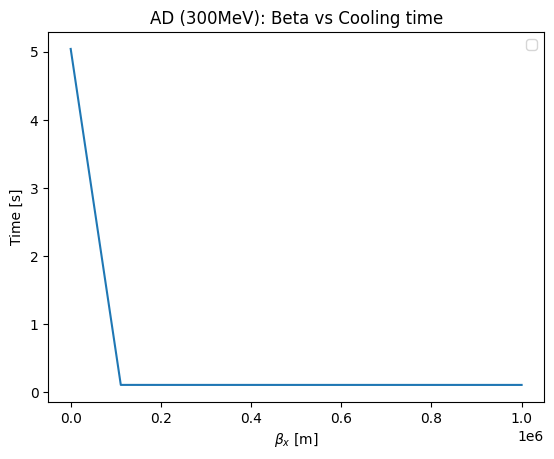

In [5]:
# Plot the horizontal action versus time
plt.figure()
plt.plot(beta_values,cooling_time)
plt.xlabel(r'$\beta_x$ [m]')
plt.ylabel('Time [s]')
plt.title('AD (300MeV): Beta vs Cooling time')
plt.legend()
plt.ticklabel_format(useOffset=False)

